# Предсказание вероятности исходов футбольных матчей

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.linear_model import  LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from tqdm import tqdm_notebook
from copy import copy
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from sklearn.model_selection import train_test_split

display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

## Чтение данных...

In [199]:
folder_names = {"02-03/","03-04/","04-05/","05-06/","07-08/","08-09/","09-10/","10-11/",
                "11-12/","12-13/","13-14/","14-15/","15-16/","16-17/","17-18/"}

In [200]:
names = {"E0.csv"}

In [198]:
names = {"B1.csv","D1.csv","D2.csv","E0.csv","E1.csv","E2.csv","E3.csv","EC.csv",
         "F1.csv","F2.csv","G1.csv","I1.csv",
        "I2.csv","N1.csv","P1.csv","SC0.csv","SC1.csv","SC2.csv","SC3.csv",
         "SP1.csv","SP2.csv","T1.csv",}


In [201]:
count = 0
columns = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR','B365H','B365D','B365A']
files = []  
fail_files = []
train_size = 0
data = pd.DataFrame(columns=columns)
for folder in folder_names:
    for name in names:
        try:
            tmp = pd.read_csv('Data football/Train/' + folder + name,error_bad_lines=False)
            if 'HST' in tmp.columns:
                data = data.append(tmp[columns])
                train_size += len(tmp)
                files.insert(len(files),folder + name)
        except:
            count += 1
            fail_files.insert(len(fail_files), folder + name)
print count, 'Fails'
print train_size, 'Total matches'

data = data.dropna(axis=0,how='any')
data['Date'] = pd.to_datetime(data.Date,dayfirst=True)
data = data.sort_values(by='Date')

Skipping line 257: expected 48 fields, saw 49
Skipping line 258: expected 48 fields, saw 49
Skipping line 259: expected 48 fields, saw 49
Skipping line 260: expected 48 fields, saw 49
Skipping line 261: expected 48 fields, saw 49
Skipping line 262: expected 48 fields, saw 49
Skipping line 263: expected 48 fields, saw 49
Skipping line 264: expected 48 fields, saw 49
Skipping line 265: expected 48 fields, saw 49
Skipping line 266: expected 48 fields, saw 49
Skipping line 267: expected 48 fields, saw 49
Skipping line 268: expected 48 fields, saw 49
Skipping line 269: expected 48 fields, saw 49
Skipping line 270: expected 48 fields, saw 49
Skipping line 271: expected 48 fields, saw 49
Skipping line 272: expected 48 fields, saw 49
Skipping line 273: expected 48 fields, saw 51
Skipping line 274: expected 48 fields, saw 51
Skipping line 275: expected 48 fields, saw 51
Skipping line 276: expected 48 fields, saw 51
Skipping line 277: expected 48 fields, saw 51
Skipping line 278: expected 48 fie

0 Fails
5267 Total matches


In [5]:
data.to_csv('data.csv',index=False)

In [202]:
data.to_csv('ENG.csv',index=False)

In [203]:
data = pd.read_csv('ENG.csv')

In [6]:
data = pd.read_csv('data.csv')

In [204]:
teams_list = Counter(data['HomeTeam']).keys()

In [205]:
for team in tqdm_notebook(teams_list):
    home_matches = pd.DataFrame(data.loc[data['HomeTeam'] == team])
    away_matches = pd.DataFrame(data.loc[data['AwayTeam'] == team])
    columns = away_matches.columns
    
    
    for i in xrange(3,len(columns)-3,2):
        tmp = copy(away_matches.loc[:,columns[i]])
        away_matches.loc[:,columns[i]] = away_matches.loc[:,columns[i + 1]]
        away_matches.loc[:,columns[i + 1]] = tmp
    tmp = copy(away_matches.loc[:,'B365H'])
    away_matches.loc[:,'B365H'] = away_matches.loc[:,'B365A']
    away_matches.loc[:,'B365A'] = tmp
    home_matches.loc[:,'location'] = np.ones(len(home_matches))
    away_matches.loc[:,'location'] = np.zeros(len(away_matches))
    
    
    
    team_data = pd.concat([home_matches,away_matches])
    team_data = team_data.sort_values(by='Date')
    
    #team_data.to_csv('Teams/' + team + '.csv',index=False)
    team_data.to_csv('TeamsENG/' + team + '.csv',index=False)
   

In [206]:
N_history = 10
data.loc[:,'usable'] = np.zeros((len(data),1))
data.head()
columns = xrange(15 * 2 * (N_history - 1) + 3)
df = pd.DataFrame(columns=columns)
for i in tqdm_notebook(xrange(len(data))):    

    #home = pd.read_csv('Teams/' + data.loc[i,'HomeTeam'] + '.csv')
    #away = pd.read_csv('Teams/' + data.loc[i,'AwayTeam'] + '.csv')
    home = pd.read_csv('TeamsENG/' + data.loc[i,'HomeTeam'] + '.csv')
    away = pd.read_csv('TeamsENG/' + data.loc[i,'AwayTeam'] + '.csv')
    home_match = home.loc[home['Date'] == data.loc[i,'Date']]
    away_match = away.loc[away['Date'] == data.loc[i,'Date']]
    upper_index_home = home_match.index[0]
    upper_index_away = away_match.index[0]
    lower_index_home = upper_index_home - N_history + 1
    lower_index_away = upper_index_away - N_history + 1
    if lower_index_home < 0 or lower_index_away < 0:
        continue
    slice_home = home.loc[lower_index_home:upper_index_home - 1]
    slice_away = away.loc[lower_index_away:upper_index_away - 1]
    slice_home = slice_home.drop(['Date','HomeTeam','AwayTeam','B365H','B365D','B365A'],axis=1)
    slice_away = slice_away.drop(['Date','HomeTeam','AwayTeam','B365H','B365D','B365A'],axis=1)
    home_features = np.asarray(slice_home)
    away_features = np.asarray(slice_away)
    home_features = home_features.reshape(home_features.shape[0] * home_features.shape[1])
    away_features = away_features.reshape(away_features.shape[0] * away_features.shape[1])
    coeff = data.loc[i,['B365H','B365D','B365A']]
    features = np.hstack((home_features,away_features,coeff))
    ser = pd.Series(features,index=columns)
    df = df.append(ser,ignore_index=True)
    data.loc[i,'usable'] = 1
    
df.to_csv('df_10_ENG.csv',index=False)
data.to_csv('data_10_ENG.csv', index=False)

In [3]:
'''
data = pd.read_csv('data_3_ENG.csv')
data = data.loc[data['usable'] == 1.0]
df = pd.read_csv('df_3_ENG.csv')

'''
data = pd.read_csv('data_3_.csv')
data = data.loc[data['usable'] == 1.0]
df = pd.read_csv('df_3_.csv')


for i in xrange(len(df)):
    if df.loc[i,'60'] == 0:
        df.loc[i,'60'] = 1 - 1 / df.loc[i,'61'] - df.loc[i,'62']
for i in xrange(len(df)):
    if df.loc[i,'61'] == 0:
        df.loc[i,'61'] = 1 - 1 / df.loc[i,'60'] - df.loc[i,'62']
for i in xrange(len(df)):
    if df.loc[i,'62'] == 0:
        df.loc[i,'62'] = 1 - 1 / df.loc[i,'60'] - df.loc[i,'61']

data.loc[:,'result'] = np.sign(data['FTHG'] - data['FTAG']) + 1
data.index = range(len(data))
df.loc[:,'result'] = data.loc[:,'result']
results = np.array(data.result)
prob = np.zeros((results.shape[0],3))
for i in xrange(results.shape[0]):
    if results[i] == 2:
        prob[i] = [1,0,0]
    else:
        if results[i] == 1:
            prob[i] = [0,1,0]
        else:
            prob[i] = [0,0,1]
X = np.array(df.iloc[:,:-1])
Y = np.array(df.iloc[:,-1:])

# Подготовка данных
1) Данные были получены с сайта championat.com путем парсинга страниц

2) Данные с коэффициентами были загружены с сайта букмекерской конторы

3) Объединили две таблицы

4) Построили "временное окно для каждого матча", т.е набор признаков - статистика прошлых матчей

# Формат данных
Окно 3 матча 

In [27]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,result
0,2.0,2.0,8.0,5.0,5.0,2.0,12.0,14.0,5.0,3.0,...,9.0,1.0,3.0,0.0,0.0,0.0,1.727,3.50,4.000,1.0
1,1.0,1.0,6.0,9.0,3.0,5.0,12.0,16.0,8.0,9.0,...,12.0,2.0,1.0,0.0,0.0,0.0,1.800,3.25,4.000,2.0
2,1.0,1.0,12.0,11.0,6.0,6.0,13.0,19.0,7.0,5.0,...,8.0,2.0,3.0,0.0,0.0,0.0,1.727,3.25,4.333,1.0
3,2.0,2.0,10.0,8.0,3.0,2.0,11.0,20.0,11.0,4.0,...,2.0,1.0,0.0,0.0,0.0,0.0,1.615,3.40,5.000,2.0
4,1.0,1.0,7.0,13.0,6.0,10.0,15.0,13.0,8.0,6.0,...,2.0,2.0,3.0,0.0,0.0,0.0,2.200,3.25,2.800,0.0


Статистика за матч состоит из голов, ударов по воротам, нарушений и т.д

In [4]:
gkf = KFold(n_splits=5, shuffle=True)
model = RandomForestClassifier(n_estimators=100,n_jobs=-1)
logic_prob_model = LogisticRegression()

In [5]:
for train, test in gkf.split(X, Y):
    X_train, y_train = X[train], Y[train]
    X_test, y_test = X[test], Y[test]     
    logic_prob_model.fit(X_train, y_train)
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    logic_probs = logic_prob_model.predict_proba(X_test) 
    print 'Acc', accuracy_score(y_test,prediction)
    print 'Roc auc'
    print roc_auc_score(y_true=prob[test,0], y_score=logic_probs[:,2])
    print roc_auc_score(y_true=prob[test,1], y_score=logic_probs[:,1])
    print roc_auc_score(y_true=prob[test,2], y_score=logic_probs[:,0])
    print 

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Acc 0.48698017878
Roc auc
0.668465289175
0.543310489923
0.675998431668

Acc 0.484065293432
Roc auc
0.677086079569
0.537800645774
0.678944115252

Acc 0.475806451613
Roc auc
0.657524745994
0.541067415133
0.667636209897

Acc 0.483773804897
Roc auc
0.663795136325
0.547115453273
0.675663652234

Acc 0.497959580257
Roc auc
0.676589560495
0.539258882161
0.685192764527



In [9]:
X = np.array(df.iloc[:,:-1])
Y = np.array(df.iloc[:,-1:])
split = 50000
logic_prob_model = LogisticRegression(C=0.01)
#X_train, X_test,y_train, y_test = train_test_split(X,Y)
#split = X_train.shape[0]


X_train = X[:split]
y_train = Y[:split]
X_test = X[split:]
y_test = Y[split:]

logic_prob_model.fit(X_train,y_train)
print 'Accuracy', logic_prob_model.score(X_test,y_test)


logic_prob_model.fit(X_train, y_train)
logic_probs = logic_prob_model.predict_proba(X_test) 
print 'Roc auc'
print roc_auc_score(y_true=prob[split:,0], y_score=logic_probs[:,2])
print roc_auc_score(y_true=prob[split:,1], y_score=logic_probs[:,1])
print roc_auc_score(y_true=prob[split:,2], y_score=logic_probs[:,0])



Accuracy 0.539726027397
Roc auc
0.717484563692
0.547478015337
0.749752606411


# Победы хозяев

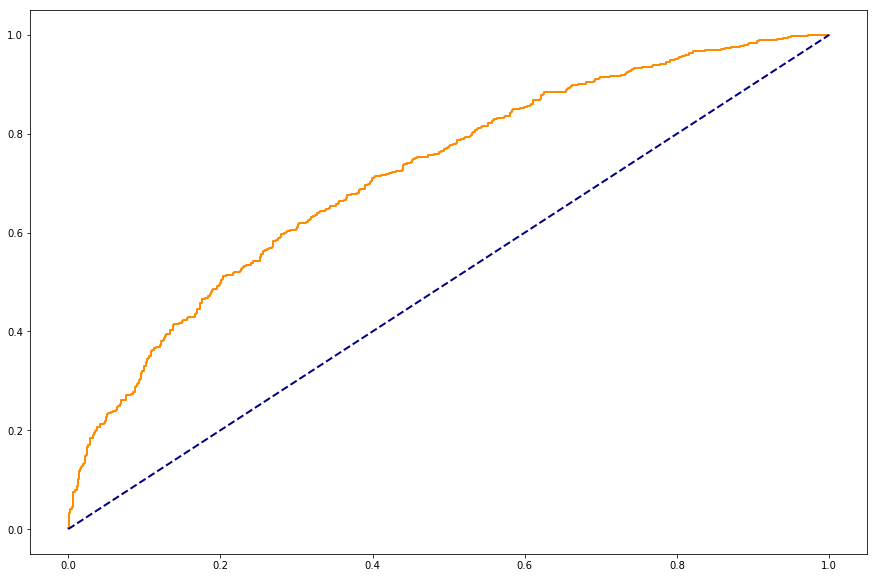

In [12]:
plt.rcParams['figure.figsize'] = (15,10)
fpr, tpr, _ = roc_curve(prob[split:,0], logic_probs[:,2])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Ничьи

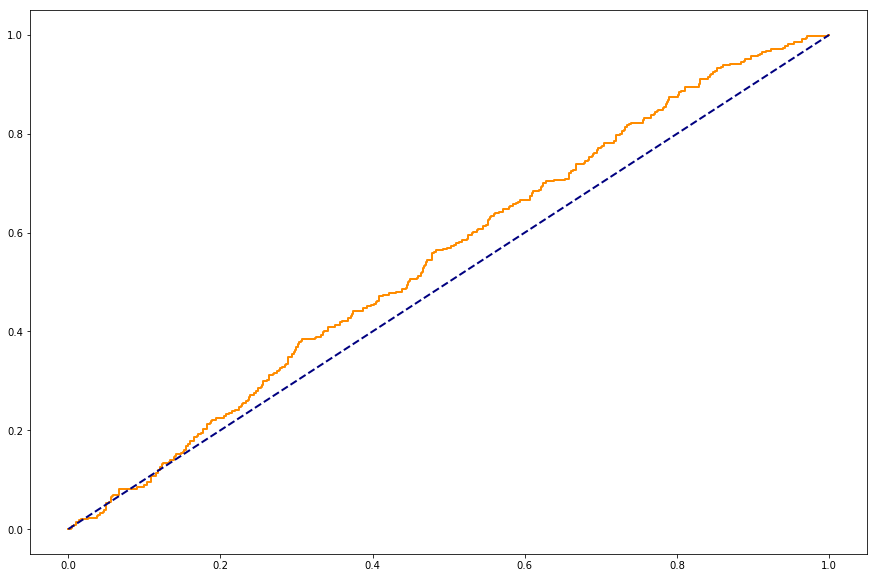

In [13]:
plt.rcParams['figure.figsize'] = (15,10)
fpr, tpr, _ = roc_curve(prob[split:,1], logic_probs[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Победы гостей

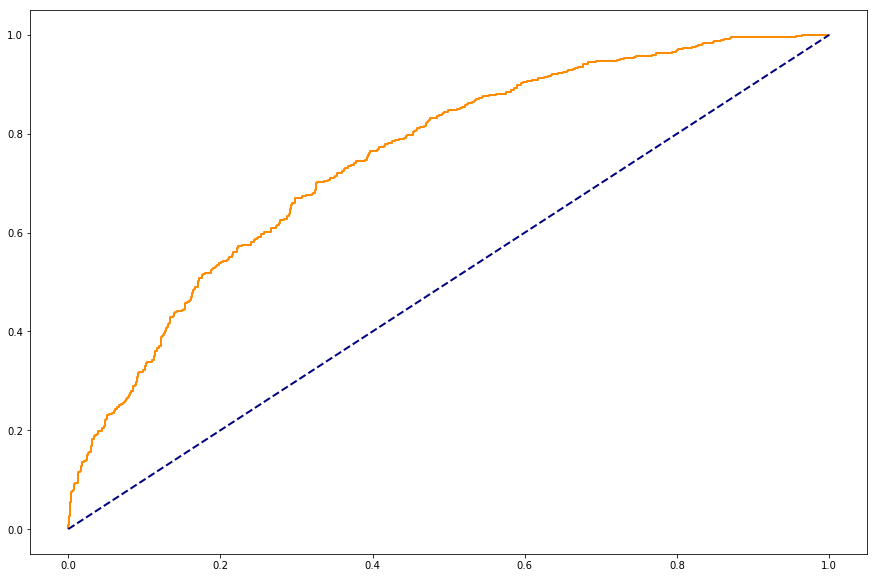

In [14]:
plt.rcParams['figure.figsize'] = (15,10)
fpr, tpr, _ = roc_curve(prob[split:,2], logic_probs[:,0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

In [19]:
weigts = logic_prob_model.coef_[2]

Явная зависимость предсказания от коэффициентов букмекеров

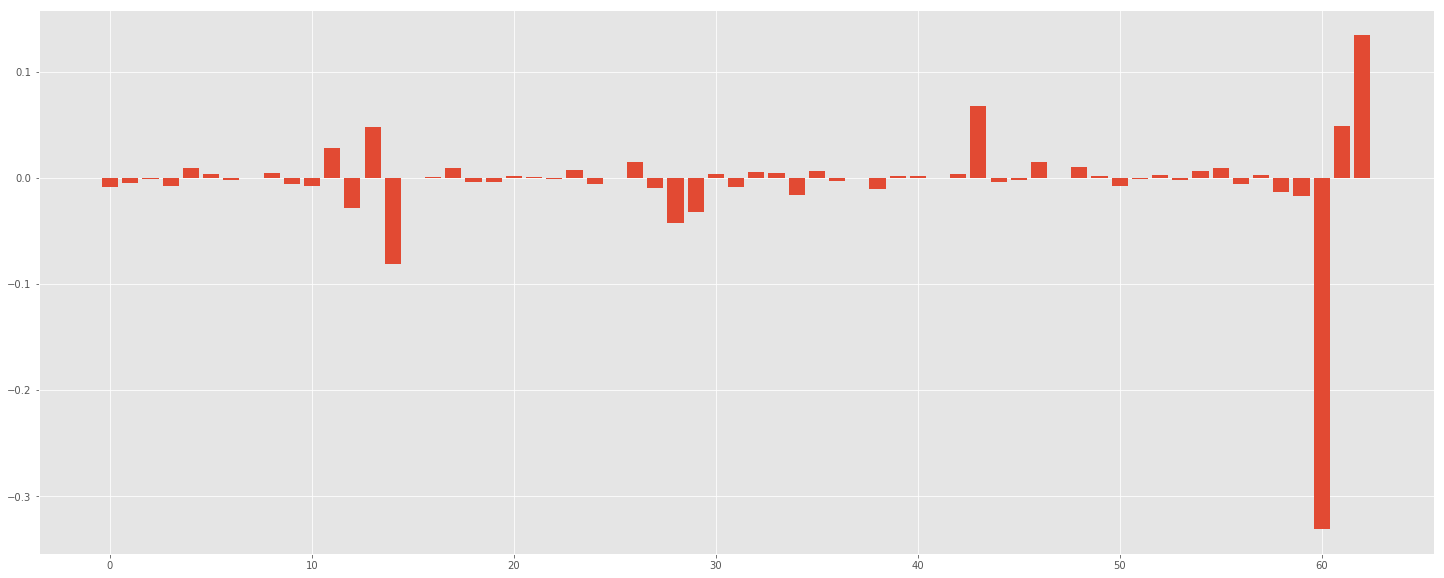

In [20]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (25,10)
plt.figure()
plt.bar(range(len(weigts)),weigts)
plt.show()

# "Бизнес" параметр

In [22]:
q = 10000
win_bank = 0.0
cash = []
max_bet = q / 5
check_data = pd.DataFrame(columns=['My prob', 'Book prob', 'Coeff', 'Bet size', 'Match result', 'Total cash', 'Bet result'])
# 0 - гости, 1 - ничья, 2 - хозяева
prediction_type = 2
# 62 - гости, 61 - ничья, 60 - хозяева
ind = 62 - prediction_type


for i in tqdm_notebook(xrange(len(y_test))):
    bet_size = 0
    bet_result = ''
    if logic_probs[i,prediction_type] > 1 / X_test[i,ind]:# and X_test[i,ind] > 3.0:        
        bet_size = q * (X_test[i,ind] * logic_probs[i][prediction_type] - 1) / (X_test[i,ind] - 1)
        if bet_size > max_bet:
            bet_size = max_bet
        q -= bet_size
        if y_test[i] == prediction_type:
            q += bet_size * X_test[i,ind]
            bet_result = 'WIN'
        else:
            bet_result = 'LOSE'
    else:
        bet_result = 'NO BET'
    max_bet = q / 5
    ser = pd.Series([logic_probs[i][prediction_type], 1 / X_test[i,ind], X_test[i,ind], bet_size, y_test[i],q, bet_result],index=check_data.columns)
    check_data = check_data.append(ser,ignore_index=True)
    cash.insert(len(cash), q)

check_data.loc[check_data['Match result'] == 2.0, 'Match result'] = 'HOME'
check_data.loc[check_data['Match result'] == 1.0, 'Match result'] = 'DRAW'
check_data.loc[check_data['Match result'] == 0.0, 'Match result'] = 'AWAY'
check_data.loc[:,'HomeTeam'] = data.loc[split:].HomeTeam.values
check_data.loc[:,'AwayTeam'] = data.loc[split:].AwayTeam.values
check_data.loc[:,'Goals dif'] = data.loc[split:].FTHG.values - data.loc[split:].FTAG.values
print 'max cash', np.max(cash)
print 'min cash', np.min(cash)
print 'avg cash', np.mean(cash)
print 'result cash', q




max cash 34293.3228475
min cash 6369.38656718
avg cash 14426.3310501
result cash 10703.1045767


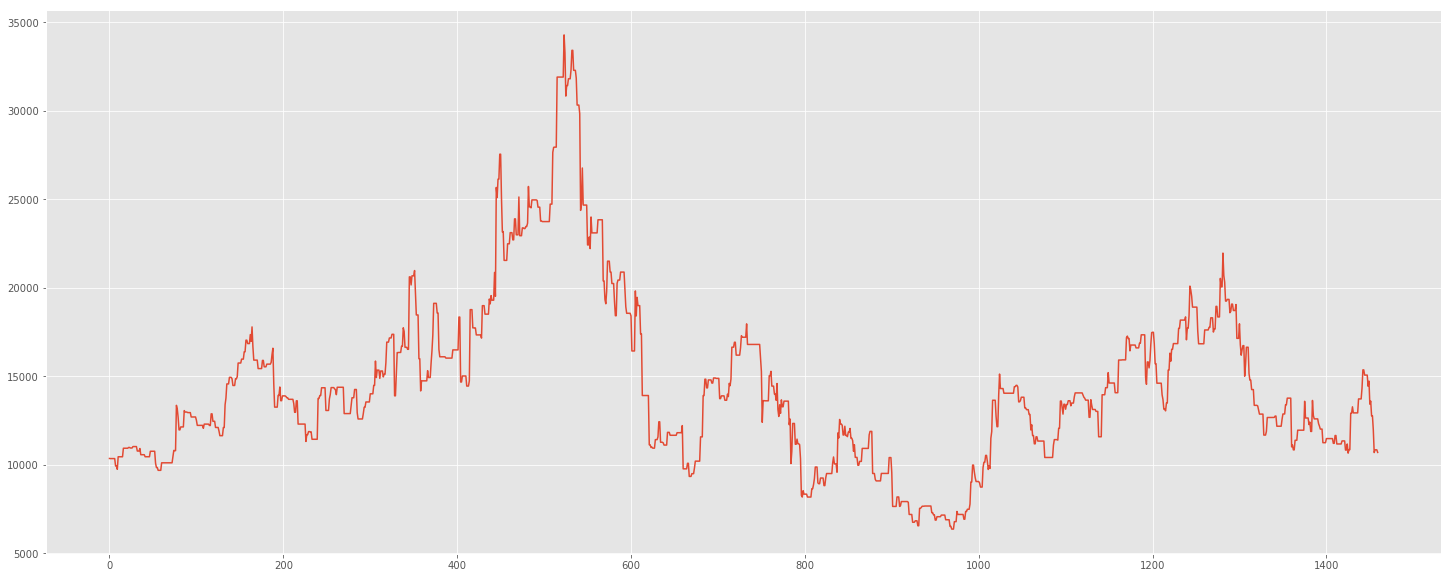

In [23]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (25,10)
plt.figure()
Y = check_data['Total cash']
X = range(len(check_data))
plt.plot(X,Y)
plt.show()


In [24]:
Counter(check_data['Bet result'])

Counter({'LOSE': 297, 'NO BET': 873, 'WIN': 290})